# MNIST notebook

## import libraries

In [38]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

## Import the dataset

In [39]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator
import numpy as np
import random

# Set the random seeds for reproducibility
random_seed = 400  # You can choose any seed number

# Set the random seed for Python's built-in random module
random.seed(random_seed)

# Set the random seed for NumPy
np.random.seed(random_seed)

# Set the random seed for TensorFlow
tf.random.set_seed(random_seed)


In [40]:
import tensorflow as tf
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter for only the classes 3 and 6
train_filter = np.where((y_train == 6) | (y_train == 3))
test_filter = np.where((y_test == 6) | (y_test == 3))

x_train, y_train = x_train[train_filter], y_train[train_filter]
x_test, y_test = x_test[test_filter], y_test[test_filter]

# Use the first 500 images as the training set
x_train, y_train = x_train[:500], y_train[:500]
# Randomly sample 300 images from the remaining data as the validation set
x_val, y_val = x_test[500:800], y_test[500:800]

x_test, y_test = x_test[:300], y_test[:300]

# Rescale the images
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

print("Training set shape:", x_train.shape)
print("Validation set shape:", x_val.shape)
print("Test set shape:", x_test.shape)


Training set shape: (500, 28, 28)
Validation set shape: (300, 28, 28)
Test set shape: (300, 28, 28)


In [41]:
# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly

train_images = np.expand_dims(x_train, -1)
validation_images = np.expand_dims(x_val, -1)
test_images = np.expand_dims(x_test, -1)

def preprocess_images(images):
    # Center-crop to 24x24
    images_cropped = tf.image.central_crop(images, central_fraction=24/28)
    
    # Down-sample to 4x4
    images_downsampled = tf.image.resize(images_cropped, size=(4, 4), method=tf.image.ResizeMethod.BILINEAR)
    
    return images_downsampled

# Preprocess the train, validation, and test images
train_images_processed = preprocess_images(train_images)
validation_images_processed = preprocess_images(validation_images)
test_images_processed = preprocess_images(test_images)

# Map the labels 3 -> 0 and 6 -> 1
y_train_binary = np.where(y_train == 3, 0, 1)
y_val_binary = np.where(y_val == 3, 0, 1)
y_test_binary = np.where(y_test == 3, 0, 1)

# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(y_train_binary, 2)
validation_labels = to_categorical(y_val_binary, 2)
test_labels = to_categorical(y_test_binary, 2)

print("Shape of train labels:", train_labels.shape)
print("Shape of validation labels:", validation_labels.shape)
print("Shape of test labels:", test_labels.shape)

Shape of train labels: (500, 2)
Shape of validation labels: (300, 2)
Shape of test labels: (300, 2)


In [42]:
unique_labels = np.unique(y_train)
print(f"Unique labels in the training set: {unique_labels}")

Unique labels in the training set: [3 6]


In [43]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    grid_size = 5
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

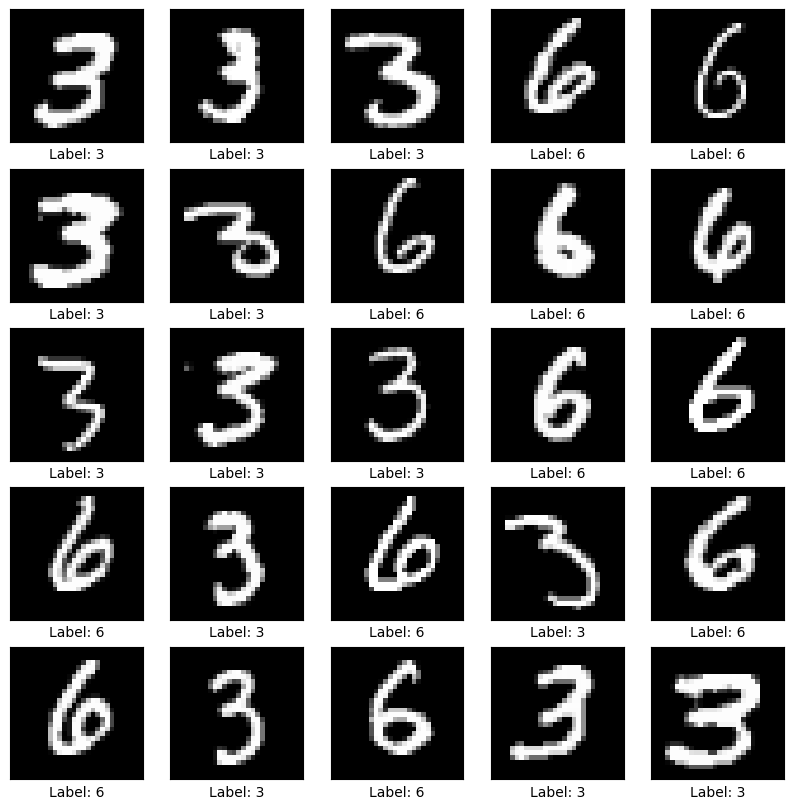

In [44]:
#Plot some of the images with their labels
plot_images(x_train, y_train, num_images=25, figsize=(10,10))

## Common Quantum functions

In [45]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < (parameters.shape[0]):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

# OrthNN

In [46]:
class HybridModel(tf.keras.Model):
    def __init__(self, apply_quantum_dropout=False, keep_prob=0.7):
        super(HybridModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32
        )
        self.apply_quantum_dropout = apply_quantum_dropout  # Flag for applying quantum dropout
        self.keep_prob = keep_prob  # Probability of keeping a qubit (1 - dropout probability)
        self.dev = qml.device('default.qubit.tf', wires=6)

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights, dropout_mask=None):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)

            # Load the input into the quantum circuit
            vector_loader(convert_array(inputs), wires=range(6))
            
            # Apply dropout mask to qubits (if dropout is enabled)
            if dropout_mask is not None:
                for i, drop in enumerate(dropout_mask):
                    if drop == 1:  # Only apply gate if qubit is not dropped
                        pyramid_circuit(weights, wires=[i])  # Ensure wires is a list
            else:
                pyramid_circuit(weights, wires=range(6))

            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_2 = tf.keras.layers.Dense(2, activation='softmax', dtype=tf.float64)

    def apply_quantum_dropout_mask(self):
        """Generate a dropout mask for qubits."""
        if self.apply_quantum_dropout:
            # Create a binary mask: 1 means keep the qubit, 0 means drop it
            dropout_mask = np.random.binomial(1, self.keep_prob, size=6)
        else:
            dropout_mask = np.ones(6)  # Keep all qubits if dropout is not applied
        return dropout_mask

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)

        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(
                self.quantum_circuit(x, self.quantum_weights, self.apply_quantum_dropout_mask())
            ),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )

        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        # nn_output = self.classical_nn_1(quantum_outputs)
        nn_output = self.classical_nn_2(quantum_outputs)

        return nn_output





In [47]:
model = HybridModel(apply_quantum_dropout=True)
# Define the total number of steps (epochs * steps per epoch)
total_steps = 100  # Example value; adjust based on your training setup

# Cosine learning rate scheduler from 0.3 to 0.03
initial_learning_rate = 0.3
final_learning_rate = 0.03

# Calculate the alpha (final learning rate ratio) for the cosine scheduler
alpha = final_learning_rate / initial_learning_rate

# Cosine decay learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=total_steps,
    alpha=alpha
)

# Adam optimizer with the cosine scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Start training
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)


Epoch 1/20


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.8145 - loss: 0.4576 - val_accuracy: 0.9633 - val_loss: 0.1065
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9828 - loss: 0.0562 - val_accuracy: 0.9767 - val_loss: 0.0644
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9873 - loss: 0.0433 - val_accuracy: 0.9733 - val_loss: 0.0659
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9937 - loss: 0.0284 - val_accuracy: 0.9800 - val_loss: 0.0624
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.9937 - loss: 0.0204 - val_accuracy: 0.9800 - val_loss: 0.0614
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9937 - loss: 0.0155 - val_accuracy: 0.9800 - val_loss: 0.0613
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9937 - loss: 0.0132 - val_accuracy: 0.9800 - val_loss: 0.0611
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9937 - loss: 0.0119 - val_accuracy: 0.9800 - val_loss: 0

In [50]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9786 - loss: 0.0747
Test Loss: 0.08442899584770203
Test Accuracy: 0.9800000190734863


In [26]:
import numpy as np
for i in range(10):
    dropout_mask = np.random.binomial(1, 0.5, size=6)
    print(dropout_mask)

[0 1 1 0 0 0]
[1 1 0 1 1 1]
[0 1 1 1 0 1]
[1 0 1 1 1 1]
[0 0 0 0 1 1]
[1 0 1 1 0 1]
[1 1 1 1 0 0]
[0 1 1 1 0 1]
[0 1 1 0 0 1]
[1 0 1 1 1 0]
